# Objective

Help a nonprofit organization YoLocal Snack find a location to open up a store. Their goal is to provide nourishing local snacks and drinks to daily commuters during common meal hours. To make the most impact, YoLocal Snack's ideal store location is by a subway station in a local community with a large population of New Yorkers with long weekday commute times.  

#### Common Meal Hours
- 8am-12pm = breakfast 
- 12pm-4pm = lunch
- 4pm-8pm = happy hour

### Find the High Traffic Commuter Stations

We want high entry numbers in the morning and high exit numbers in the evening, and for the morning entry traffic and evening traffic to be similar by the end of the day. This indicates a strong population of 9 to 5 workers and students residing near a particular station.

```Note: Within these commuter stations are outliers with very high traffic because New Yorkers travel to certain stations to exit for work or transfer to another form of transportation. All of these stations are in Manhattan and will be excluded from our list of commuter stations because it is difficult to determine if the commuters in Manhattan are traveling a long distance. We can use this data to show where commuters are in certain points of day.```

### Establishing Long Distance Commuters

The NYC MTA Subway map reveals that the majority of subway stations in boroughs outside of Manhattan contain only one or two lines. These stations serve different neighborhoods and the distance between each line and Manhattan establishes a clear distinction of a long commute.  

### Further checks

After identifying potential stations, we can do a google search of the station to see how many local snack stores are nearby. Google's activity tracker reveals if the stores see an increase in traffic during meal hours. In the future, YoLocal Snack will work with these vendors to efficiently cater to local commuters. 

# Gathering Data

MTA data from January 2021 to April 2021 will form the basis of my analysis. This is a good time frame to look at New York's commuter cycle. Students go back to school in January and workers resume work after major holidays. Additionally, the turnstile data has reset so it's possible to detect where anomalies begin and decide what to do with them. Decreases in commuter traffic due to COVID is not a concern because YoLocal Snack is serving New Yorkers who need to commute to work.


### MTA Turnstile Data 

##### Purpose: 

- Entry and Exit Traffic Numbers
- Stations and Line Names
- Date and Time  

### MTA Location Data

##### Purpose: 

- Borough
- Latitude and Longitude

### MTA RIDERSHIP DATA

##### Purpose: 

- The total ridership from January 1, 2021 to April 23, 2021 is [171,715,108](https://new.mta.info/document/20441)
- Estimate daily ridership

In [160]:
from sqlalchemy import create_engine
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
import datetime 
from datetime import timedelta
%config InlineBackend.figure_format = 'svg'
%matplotlib inline 

In [2]:
pd.set_option('display.max.colwidth', None)

# Loading the Data

Make a daily total dataframe by loading the csv with pandas. 

Access the mta database with sql alchemy and left join the turnstile table with location data by Stop_Name and Division. Then create a dataframe with the joined tables.

- " WITH turnstile21_data as 
- (SELECT * FROM turnstile_data WHERE DATE LIKE '%2021')
- SELECT t.*, l.Borough, l.GTFS_Latitude, l.GTFS_Longitude
- FROM turnstile21_data t LEFT JOIN location_data l
- ON t.STATION = upper(l.Stop_Name) AND t.DIVISION = l.Division;"

The top code works, but takes a long time to load on dbrowser so I will not use it on jupyter notebook. I'll have to import them individually and join them through pandas. 

In [3]:
daily_total_riders_url = "https://new.mta.info/document/20441"
daily_total_raw_df = pd.read_csv(daily_total_riders_url)
daily_total_raw_df.rename(columns = {'Date': 'DATE', 'Subways: Total Estimated Ridership':'SUBWAY_TOTAL'}, inplace = True)
daily_total_df = daily_total_raw_df.loc[:, ['DATE','SUBWAY_TOTAL']]
daily_total_df['YEAR'] = daily_total_df['DATE'].str.extract(r'\b(\d+)$')
daily_total_21_df = daily_total_df[daily_total_df['YEAR'] == '2021']

In [4]:
total_traffic_21 = daily_total_21_df.groupby('YEAR')['SUBWAY_TOTAL'].sum()['2021']

In [5]:
engine = create_engine("sqlite:///Data/mta.db")

In [6]:
turnstile_df_21 = pd.read_sql("SELECT * FROM turnstile_data WHERE DATE LIKE '%2021';", engine)

In [7]:
turnstile_df_21.columns = turnstile_df_21.columns.str.replace(' ','')

In [8]:
location_df = pd.read_sql("SELECT Stop_Name, Division, Borough, GTFS_Latitude, GTFS_Longitude FROM location_data;", engine)

In [9]:
location_df['Stop_Name'] = location_df['Stop_Name'].str.upper()

In [10]:
turn_loc_21_df = turnstile_df_21.merge(location_df, how = 'left', left_on=['STATION'], right_on=['Stop_Name'])

In [11]:
turn_loc_21_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5588236 entries, 0 to 5588235
Data columns (total 16 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   C/A             object
 1   UNIT            object
 2   SCP             object
 3   STATION         object
 4   LINENAME        object
 5   DIVISION        object
 6   DATE            object
 7   TIME            object
 8   DESC            object
 9   ENTRIES         object
 10  EXITS           object
 11  Stop_Name       object
 12  Division        object
 13  Borough         object
 14  GTFS_Latitude   object
 15  GTFS_Longitude  object
dtypes: object(16)
memory usage: 724.8+ MB


In [12]:
turn_loc_21_df.describe()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Stop_Name,Division,Borough,GTFS_Latitude,GTFS_Longitude
count,5588236,5588236,5588236,5588236,5588236,5588236,5588236,5588236,5588236,5588236,5588236,4321745,4321745,4321745,4.321745e+06,4.321745e+06
unique,749,468,226,378,114,6,113,62524,2,2127757,2686004,254,4,5,3.510000e+02,3.510000e+02
top,A046,R014,00-00-00,FULTON ST,1,IRT,01/11/2021,08:00:00,REGULAR,0000000000,0000000000,FULTON ST,IRT,M,4.071037e+01,-7.400657e+01
freq,77262,169430,495493,325290,587457,2137658,50549,410852,5566293,72734,24039,325290,1632399,2548759,6.505800e+04,6.505800e+04


In [13]:
turn_loc_21_df['ENTRIES'] = turn_loc_21_df['ENTRIES'].astype('int')
turn_loc_21_df['EXITS'] = turn_loc_21_df['EXITS'].astype('int')

In [14]:
turn_loc_21_df['ENTRIES'].describe()

count    5.588236e+06
mean     4.660695e+07
std      2.304732e+08
min      0.000000e+00
25%      2.624360e+05
50%      1.756415e+06
75%      6.727134e+06
max      2.147432e+09
Name: ENTRIES, dtype: float64

In [15]:
turn_loc_21_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Stop_Name,Division,Borough,GTFS_Latitude,GTFS_Longitude
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,03:00:00,REGULAR,7511448,2558786,59 ST,BMT,Bk,40.6414,-74.0179
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,03:00:00,REGULAR,7511448,2558786,59 ST,IRT,M,40.7625,-73.968
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,07:00:00,REGULAR,7511451,2558789,59 ST,BMT,Bk,40.6414,-74.0179
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,07:00:00,REGULAR,7511451,2558789,59 ST,IRT,M,40.7625,-73.968
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,11:00:00,REGULAR,7511461,2558813,59 ST,BMT,Bk,40.6414,-74.0179


# DATA CLEANING Part 1

A quick exploration of the dataset reveals many cleaning tasks. There are duplicate rows, the exits and entries columns contain outliers that are far from the mean, the time column reveals 62524 instead of the expected 7. The entries and exits columns show cumulative values instead of the number of entries at that point in time. 

The next steps will include:
1. Reformat the unique 62524 time values to the standard 
2. Combine DATE and TIME and create an indentification for a unique turnstile
3. Create a day column 
4. Locate the outliers 
5. Removing the duplicate values 

In [16]:
temp_time = turn_loc_21_df['TIME'].reset_index().copy()

In [17]:
temp_time['first3'] = temp_time['TIME'].str[:4]
temp_time['first3'] = temp_time['first3'].str.replace(":", ".").astype('float')
temp_time['first3'] = temp_time['first3'].apply(lambda x: np.round(x,0))

In [18]:
time_bin = [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0]
temp_time['first3'] = temp_time['first3'].apply(lambda x: time_bin[np.digitize(x,time_bin, right = True)])

In [19]:
temp_time['first3'] = temp_time['first3'].astype('string')

In [20]:
time_dict = {'0.0': '00:00:00' , '4.0': '04:00:00' , '8.0': '08:00:00' , '12.0': '12:00:00', 
             '16.0': '16:00:00', '20.0': '20:00:00', '24.0': '00:00:00' }
temp_time['first3'] = temp_time['first3'].map(time_dict)

In [21]:
time_list = list(temp_time['first3'])
turn_loc_21_df['TIME'] = time_list

In [22]:
turn_loc_21_df['TIME'].nunique()

6

In [23]:
mta_dfs = [turn_loc_21_df]

for mta_df in mta_dfs:
    
    mta_df['DATETIME'] = pd.to_datetime(mta_df.DATE + " " + mta_df.TIME, 
                                        format="%m/%d/%Y %H:%M:%S")
    
    mta_df['TURNSTILES'] = mta_df['C/A'] + "-" +\
                           mta_df['UNIT'] + "-" +\
                           mta_df['SCP'] + "-" +\
                           mta_df['STATION'] 

In [24]:
day_of_week_dict = dict(enumerate(calendar.day_name))
month_of_year_dict = dict(enumerate(calendar.month_name))
turn_loc_21_df['DAYNAME'] = turn_loc_21_df['DATETIME'].dt.weekday.map(day_of_week_dict)
turn_loc_21_df['MONTHNAME'] = turn_loc_21_df['DATETIME'].dt.month.map(month_of_year_dict)

In [27]:
turn_loc_21_df.columns = turn_loc_21_df.columns.str.upper()
turn_loc_21_df = turn_loc_21_df[['TURNSTILES', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 
                                   'BOROUGH', 'GTFS_LATITUDE', 'GTFS_LONGITUDE', 'DATETIME', 
                                   'DATE', 'DAYNAME', 'TIME','ENTRIES', 'EXITS']]

In [29]:
(turn_loc_21_df.groupby(['TURNSTILES','DATETIME'])
['ENTRIES', 'EXITS'].count()
.reset_index()
.sort_values(["ENTRIES", "EXITS"], ascending=False)).head(30)

<ipython-input-29-c5cc8e593b6b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  (turn_loc_21_df.groupby(['TURNSTILES','DATETIME'])


,TURNSTILES,DATETIME,ENTRIES,EXITS
2796634,R307-R207-01-00-00-135 ST,2021-01-11 16:00:00,268,268
2798663,R307-R207-01-05-00-135 ST,2021-01-11 16:00:00,246,246
2797309,R307-R207-01-00-01-135 ST,2021-01-11 16:00:00,238,238
2799339,R307-R207-01-05-01-135 ST,2021-01-11 16:00:00,226,226
2797986,R307-R207-01-00-02-135 ST,2021-01-11 16:00:00,202,202
75123,A031-R083-00-00-00-23 ST,2021-01-16 20:00:00,80,80
76470,A031-R083-00-00-02-23 ST,2021-01-16 20:00:00,80,80
77147,A031-R083-00-03-00-23 ST,2021-01-16 20:00:00,80,80
77824,A031-R083-00-03-01-23 ST,2021-01-16 20:00:00,80,80
78501,A031-R083-00-03-02-23 ST,2021-01-16 20:00:00,80,80


In [ ]:
turn_loc_21_df.sort_values(['TURNSTILES','DATETIME'], 
                   ascending = True, inplace = True)
turn_loc_21_df.drop_duplicates(subset = ['TURNSTILES', 'DATETIME'], keep = 'first',
                      inplace = True)

# DATA CLEANING Part 2

The columns are now organized and dates have been reformatted to make the dataset easier for analysis. Before I calculate the entries and exits for a turnstile, I need to perform a gutcheck. In an ideal stiatuion, the previous entry is less than the current entry in all entries in the dataframe. In the case that it is not, I need to take the absolute value of the difference between the two values.  

The next steps include filtering the dataset by:
- weekdays
- outliers
- stations with only two or one lines

Note: I was not able to find a way to calculate the total traffic to be close to the daily ridership estimated by the MTA. If I had more time I would focus on this and develop a more accurate methodology than basic filtering by quantile. Notice, the current dataframe's daily total traffic does not fluctuate as much as estimated daily ridership by the MTA. 

In the end of this cleaning I will have a new dataset with only data I require for analysis.

In [ ]:
turn_loc_21_df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (turn_loc_21_df
                                                       .groupby(["TURNSTILES"])["DATE", "ENTRIES", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))
turn_loc_21_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [58]:
mask = (turn_loc_21_df["ENTRIES"] < turn_loc_21_df["PREV_ENTRIES"])
turn_loc_21_df[mask].groupby(["TURNSTILES"]).size().sort_values(ascending = False).sum()

283492

In [59]:
max_counter = 4 * 3600 * 2 #Assuming maximum entry is someone entering a turnstile every half second

In [60]:
def entries_diff(row, max_counter):
    counter = abs(row['ENTRIES'] - row['PREV_ENTRIES'])
    if counter > max_counter:
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter
def exits_diff(row, max_counter):
    counter = abs(row['EXITS'] - row['PREV_EXITS'])
    if counter > max_counter:
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        return 0
    return counter

In [ ]:
turn_loc_21_df['ENTRIES_COUNT'] = turn_loc_21_df.apply(entries_diff, axis = 1, max_counter = max_counter)

In [ ]:
turn_loc_21_df['EXITS_COUNT'] = turn_loc_21_df.apply(exits_diff, axis = 1, max_counter = max_counter)

In [ ]:
turn_loc_21_df['TOTAL_COUNT'] = turn_loc_21_df['ENTRIES_COUNT'] + turn_loc_21_df['EXITS_COUNT']

In [66]:
weekday_mask = (turn_loc_21_df['DAYNAME'].isin(calendar.day_name[:5]))
turnwd_loc_21_df = turn_loc_21_df[weekday_mask]

In [ ]:
total75_mask = ((turn_loc_21_df['TOTAL_COUNT'] <= turn_loc_21_df['TOTAL_COUNT'].quantile(.75)) & 
(turn_loc_21_df['TOTAL_COUNT'] >= turn_loc_21_df['TOTAL_COUNT'].quantile(.25)))

In [116]:
turnwd_loc_21_df[total75_mask].groupby('DATE')['TOTAL_COUNT'].sum().sort_index().head(20)

<ipython-input-116-3f5f0d60ecae>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  turnwd_loc_21_df[total75_mask].groupby('DATE')['TOTAL_COUNT'].sum().sort_index().head(20)


DATE
01/01/2021     857751.0
01/04/2021    1032622.0
01/05/2021    1041641.0
01/06/2021    1045240.0
01/07/2021    1047552.0
01/08/2021    1036430.0
01/11/2021    1038074.0
01/12/2021    1035148.0
01/13/2021    1037437.0
01/14/2021    1033054.0
01/15/2021    1034758.0
01/18/2021    1078274.0
01/19/2021    1027089.0
01/20/2021    1058022.0
01/21/2021    1035827.0
01/22/2021    1028872.0
01/25/2021    1038337.0
01/26/2021    1073416.0
01/27/2021    1033155.0
01/28/2021    1037285.0
Name: TOTAL_COUNT, dtype: float64

In [134]:
daily_total_21_df.groupby('DATE')['SUBWAY_TOTAL'].sum().sort_index().head(20)

DATE
1/1/2021      614497
1/10/2021     763690
1/11/2021    1571330
1/12/2021    1643725
1/13/2021    1644812
1/14/2021    1650630
1/15/2021    1630098
1/16/2021     992599
1/17/2021     798564
1/18/2021    1279119
1/19/2021    1639243
1/2/2021      989612
1/20/2021    1578038
1/21/2021    1656100
1/22/2021    1675175
1/23/2021     998665
1/24/2021     741960
1/25/2021    1595694
1/26/2021    1553918
1/27/2021    1663376
Name: SUBWAY_TOTAL, dtype: int64

In [81]:
turnwd_loc_21_df[turnwd_loc_21_df['BOROUGH'].isna()]['STATION'].value_counts()

34 ST-PENN STA     49298
GRD CNTRL-42 ST    42881
ATL AV-BARCLAY     24691
42 ST-PORT AUTH    24686
59 ST COLUMBUS     19843
                   ...  
BEVERLEY ROAD       1454
138/GRAND CONC      1454
PRESIDENT ST        1453
BUSHWICK AV         1450
HARLEM 148 ST       1442
Name: STATION, Length: 124, dtype: int64

In [ ]:
turnwd_loc_21_df['IRR_ENTRIES']=turnwd_loc_21_df['ENTRIES'].apply(lambda x: len(str(x))) 
turnwd_loc_21_df['IRR_EXITS']=turnwd_loc_21_df['EXITS'].apply(lambda x: len(str(x))) 

In [121]:
c_loc_21_df = turnwd_loc_21_df[~(turnwd_loc_21_df['IRR_ENTRIES'] >= 8) & 
                            ~(turnwd_loc_21_df['IRR_EXITS'] >= 8)]

In [135]:
c_total90_mask = ((c_loc_21_df['TOTAL_COUNT'] <= c_loc_21_df['TOTAL_COUNT'].quantile(.90)) & 
(c_loc_21_df['TOTAL_COUNT'] >= c_loc_21_df['TOTAL_COUNT'].quantile(.25)))

In [ ]:
c_loc_21_df[c_total75_mask].groupby('DATE')['TOTAL_COUNT'].sum().sort_index().tail(20)

In [137]:
daily_total_21_df.groupby('DATE')['SUBWAY_TOTAL'].sum().sort_index().tail(20)

DATE
4/17/2021    1425020
4/18/2021    1082492
4/19/2021    1914793
4/2/2021     1760768
4/20/2021    2086486
4/21/2021    1969534
4/22/2021    2043789
4/23/2021    2124655
4/24/2021    1519582
4/25/2021     984641
4/26/2021    1958386
4/27/2021    2044546
4/28/2021    2135750
4/3/2021     1319964
4/4/2021      951260
4/5/2021     1822134
4/6/2021     1946071
4/7/2021     1989179
4/8/2021     2017306
4/9/2021     2030410
Name: SUBWAY_TOTAL, dtype: int64

In [139]:
borough_mask = ~(c_loc_21_df['BOROUGH'] == 'M')
c_loc_21_df = c_loc_21_df[borough_mask]

In [141]:
line_mask = (c_loc_21_df['LINENAME'].str.len() <= 2)
c_loc_21_df = c_loc_21_df[line_mask]

In [144]:
c_loc_21_df.drop(['C/A', 'UNIT', 'SCP',
       'GTFS_LATITUDE', 'GTFS_LONGITUDE', 'ENTRIES', 'EXITS', 'PREV_DATE', 'PREV_ENTRIES', 'PREV_EXITS', 'IRR_ENTRIES',
       'IRR_EXITS'], axis = 1, inplace = True)

In [ ]:
c_loc_21_df.dropna(subset=["BOROUGH"], axis=0, inplace=True)

In [147]:
c_loc_21_df['BOROUGH'].isna().sum()

0

# DATA ANALYSIS AND VIZUALIZATIONS

1. Find the top 30 commuter stations with the highest total_traffic. Plot this information to compare station traffic and to identify where they are located. 
2. Based off the top 30 commuter station, calculate the highest daily entry morning traffic, highest daily exit evening traffic, and the total between the two. Plot this information to find stations that had high entry or exit traffic and where they are similar. 
3. Using the total daily exit and entry, pick the top five stations. Plot these to find the station where daily entry is similar to daily exit
4. Check the station for consistent total commuter traffic by month and day with line graphs
5. Use a heatmap to check the usage of station during different points in time 

In [ ]:
top_30_stations_df = c_loc_21_df.groupby(['STATION','BOROUGH'])['TOTAL_COUNT'].sum().sort_values(ascending = False).head(30).reset_index()

In [ ]:
station_list = list(c_loc_21_df.groupby('STATION')['TOTAL_COUNT'].sum().sort_values(ascending = False).head(30).index)

In [200]:
station_entr_mask = ((c_loc_21_df['STATION'].isin(station_list)) &
                    ((c_loc_21_df['TIME'] == '08:00:00') | 
                    (c_loc_21_df['TIME'] == '12:00:00')))

station_exit_mask = ((c_loc_21_df['STATION'].isin(station_list)) &
                    ((c_loc_21_df['TIME'] == '16:00:00') | 
                    (c_loc_21_df['TIME'] == '20:00:00')))

In [ ]:
sumentry8_12_df = c_loc_21_df[station_entr_mask].groupby(['STATION','TIME'])['ENTRIES_COUNT'].sum().reset_index().sort_values(['STATION','TIME'], ascending=True)
sumentry8_12_df.rename({'ENTRIES_COUNT': 'TOTAL_MORNING_ENTRIES'}, axis = 1, inplace = True)

avgentry8_12_df = c_loc_21_df[station_entr_mask].groupby(['STATION','TIME'])['ENTRIES_COUNT'].mean().round(0).reset_index().sort_values(['STATION','TIME'], ascending=True)
avgentry8_12_df.rename({'ENTRIES_COUNT': 'AVG_MORNING_ENTRIES'}, axis = 1, inplace = True)

In [230]:
sumexit16_20_df = c_loc_21_df[station_entr_mask].groupby(['STATION','TIME'])['EXITS_COUNT'].sum().reset_index().sort_values(['STATION','TIME'], ascending=True)
sumexit16_20_df.rename({'EXITS_COUNT': 'TOTAL_EVENING_EXITS'}, axis = 1, inplace = True)

avgexit16_20_df = c_loc_21_df[station_entr_mask].groupby(['STATION','TIME'])['EXITS_COUNT'].mean().round(0).reset_index().sort_values(['STATION','TIME'], ascending=True)
avgexit16_20_df.rename({'EXITS_COUNT': 'AVG_EVENING_EXITS'}, axis = 1, inplace = True)

In [237]:
top_30_stations_df = (top_30_stations_df
 .merge(sumentry8_12_df.groupby('STATION')['TOTAL_MORNING_ENTRIES'].sum().reset_index(), on='STATION')
 .merge(avgentry8_12_df.groupby('STATION')['AVG_MORNING_ENTRIES'].sum().reset_index(), on='STATION')
 .merge(sumexit16_20_df.groupby('STATION')['TOTAL_EVENING_EXITS'].sum().reset_index(), on='STATION')
 .merge(avgexit16_20_df.groupby('STATION')['AVG_EVENING_EXITS'].sum().reset_index(), on='STATION'))

In [241]:
top_30_stations_df['TOTAL_MORNING_EVENING'] = top_30_stations_df['TOTAL_MORNING_ENTRIES'] + top_30_stations_df['TOTAL_EVENING_EXITS']
top_30_stations_df['DAILY_MORNING_EVENING'] = top_30_stations_df['AVG_MORNING_ENTRIES'] + top_30_stations_df['AVG_EVENING_EXITS']

In [246]:
top_5_stations_df = top_30_stations_df.sort_values('DAILY_MORNING_EVENING', ascending = False).head()
top_5_stations_df['ENTRY_EXIT_DIFF'] = abs(top_5_stations_df['AVG_MORNING_ENTRIES'] -
                                           top_5_stations_df['AVG_EVENING_EXITS'] )

In [251]:
top_30_stations_df.groupby(['STATION', 'BOROUGH'])['TOTAL_COUNT'].sum().head()

STATION      BOROUGH
111 ST       Q          1270964.0
167 ST       Bx         1655581.0
169 ST       Q          1066262.0
170 ST       Bx         1582978.0
3 AV-149 ST  Bx         1626559.0
Name: TOTAL_COUNT, dtype: float64

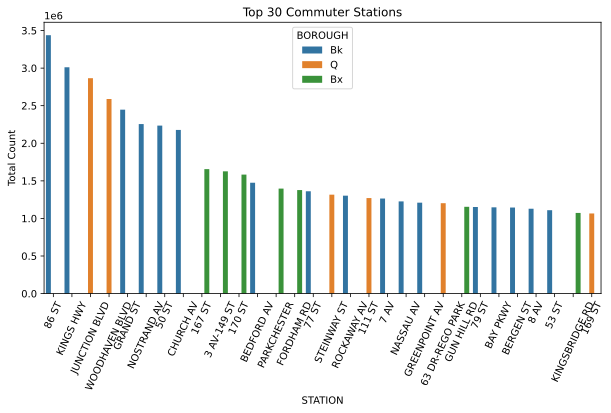

In [337]:
plt.figure(figsize = (10,5))
sns.barplot(x = 'STATION',y='TOTAL_COUNT',hue = 'BOROUGH', data = top_30_stations_df)
plt.title('Top 30 Commuter Stations')
plt.ylabel('Total Count')
plt.xticks(np.linspace(0,29,30),rotation = 65);

In [334]:
top_30_stations_df.groupby('STATION')['AVG_MORNING_ENTRIES','AVG_EVENING_EXITS'].sum().head()

<ipython-input-334-1e8897dbc448>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_30_stations_df.groupby('STATION')['AVG_MORNING_ENTRIES','AVG_EVENING_EXITS'].sum().head()


,AVG_MORNING_ENTRIES,AVG_EVENING_EXITS
STATION,,
111 ST,219.0,50.0
167 ST,332.0,157.0
169 ST,96.0,46.0
170 ST,194.0,78.0
3 AV-149 ST,191.0,125.0


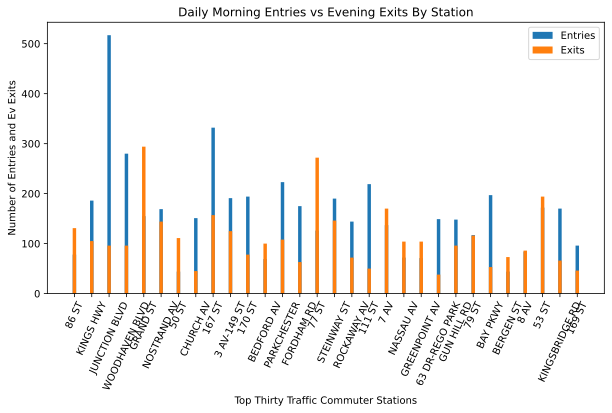

In [333]:
plt.figure(figsize = (10,5))
plt.bar(top_30_stations_df['STATION'], top_30_stations_df['AVG_MORNING_ENTRIES'], width = .2)
plt.bar(top_30_stations_df['STATION'], top_30_stations_df['AVG_EVENING_EXITS'], width = .2)
plt.title('Daily Morning Entries vs Evening Exits By Station')
plt.xlabel('Top Thirty Traffic Commuter Stations')
plt.xticks(np.linspace(0,29,30),rotation = 65)
plt.ylabel('Number of Entries and Ev Exits')
plt.legend(['Entries','Exits']);

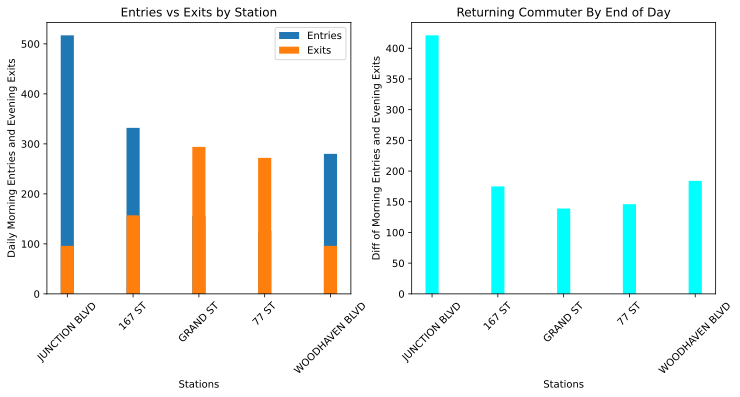

In [434]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.bar(top_5_stations_df['STATION'], top_5_stations_df['AVG_MORNING_ENTRIES'], width = .2)
plt.bar(top_5_stations_df['STATION'], top_5_stations_df['AVG_EVENING_EXITS'], width = .2)
plt.title('Entries vs Exits by Station')
plt.xlabel('Stations')
plt.xticks(np.linspace(0,4,5), rotation = 45)
plt.ylabel('Daily Morning Entries and Evening Exits')
plt.legend(['Entries','Exits'])

plt.subplot(1,2,2)
plt.bar(top_5_stations_df['STATION'], top_5_stations_df['ENTRY_EXIT_DIFF'], width = .2, color = '#00ffff')
plt.title('Returning Commuter By End of Day')
plt.xlabel('Stations')
plt.xticks(np.linspace(0,4,5), rotation = 45)
plt.ylabel('Diff of Morning Entries and Evening Exits');

In [367]:
md_mask1 = (c_loc_21_df['STATION'] == 'GRAND ST')
Grandm_df = c_loc_21_df[md_mask1].groupby('MONTHNAME')['TOTAL_COUNT'].sum().reset_index()
Grandd_df = c_loc_21_df[md_mask1].groupby('DAYNAME')['TOTAL_COUNT'].mean().round(0).reset_index()
Grandt_df = c_loc_21_df[md_mask1].groupby('TIME')['TOTAL_COUNT'].mean().round(0).reset_index()

In [423]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
Grandd_df = Grandd_df.set_index('DAYNAME').loc[day_order].reset_index()
month_order = ['January', 'February', 'March', 'April']
Grandm_df = Grandm_df.set_index('MONTHNAME').loc[month_order].reset_index()

Text(0.5, 0, 'Weekday')

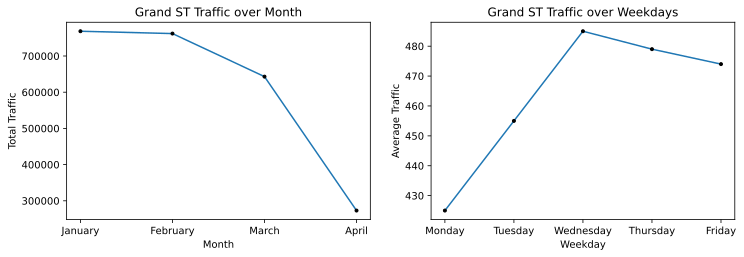

In [438]:
plt.figure(figsize = (12,8))

plt.subplot(2,2,1)
plt.plot(Grandm_df['MONTHNAME'],Grandm_df['TOTAL_COUNT'])
plt.plot(Grandm_df['MONTHNAME'],Grandm_df['TOTAL_COUNT'], '.', c = 'k')
plt.title('Grand ST Traffic over Month')
plt.ylabel('Total Traffic')
plt.xlabel('Month')

plt.subplot(2,2,2)
plt.plot(Grandd_df['DAYNAME'],Grandd_df['TOTAL_COUNT'])
plt.plot(Grandd_df['DAYNAME'],Grandd_df['TOTAL_COUNT'], '.', c = 'k')
plt.title('Grand ST Traffic over Weekdays')
plt.ylabel('Average Traffic')
plt.xlabel('Weekday')

In [385]:
Grandt_df.head()

,TIME,TOTAL_COUNT
0,00:00:00,881.0
1,04:00:00,748.0
2,08:00:00,108.0
3,12:00:00,340.0
4,16:00:00,308.0


In [384]:
Grandt_df['TIME'] = pd.to_datetime(Grandt_df['TIME'],format= '%H:%M:%S' ).dt.time
#sns.heatmap(Grandt_df['TIME'], Grandt_df['TOTAL_COUNT'], cmap='jet',annot=True);

In [373]:
md_mask2 = (c_loc_21_df['STATION'] == '77 ST')
_77m_df = c_loc_21_df[md_mask2].groupby('MONTHNAME')['TOTAL_COUNT'].sum().reset_index()
_77d_df = c_loc_21_df[md_mask2].groupby('DAYNAME')['TOTAL_COUNT'].mean().round(0).reset_index()
_77t_df = c_loc_21_df[md_mask2].groupby('TIME')['TOTAL_COUNT'].mean().round(0).reset_index()

In [425]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
_77d_df = _77d_df.set_index('DAYNAME').loc[day_order].reset_index()
month_order = ['January', 'February', 'March', 'April']
_77m_df = _77m_df.set_index('MONTHNAME').loc[month_order].reset_index()

In [375]:
_77d_df.head()

,DAYNAME,TOTAL_COUNT
0,Friday,312.0
1,Monday,284.0
2,Thursday,333.0
3,Tuesday,316.0
4,Wednesday,329.0


Text(0.5, 0, 'Weekday')

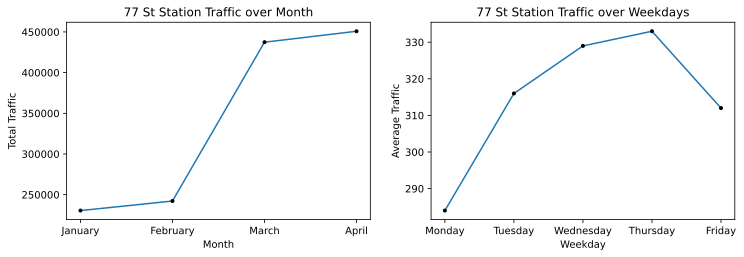

In [439]:
plt.figure(figsize = (12,8))

plt.subplot(2,2,1)
plt.plot(_77m_df['MONTHNAME'],_77m_df['TOTAL_COUNT'])
plt.plot(_77m_df['MONTHNAME'],_77m_df['TOTAL_COUNT'], '.', c = 'k')
plt.title('77 St Station Traffic over Month')
plt.ylabel('Total Traffic')
plt.xlabel('Month')

plt.subplot(2,2,2)
plt.plot(_77d_df['DAYNAME'],_77d_df['TOTAL_COUNT'])
plt.plot(_77d_df['DAYNAME'],_77d_df['TOTAL_COUNT'], '.', c = 'k')
plt.title('77 St Station Traffic over Weekdays')
plt.ylabel('Average Traffic')
plt.xlabel('Weekday')

# CONCLUSION

In the end, I believe 77 Street Station in Brooklyn shows the most promise as a prime spot for Yo-Local Snacks to open a new store. There is a similar flow of New Yorkers entering and leaving the station during meal hours. The line graph shows that traffic has steadily increased since January and February and traffic is relatively consistent during weekdays. 

# FUTURE IDEAS

1. Estimate the number of daily regular schedule commuters at a station by calculating the total number of unlimited and student metro cards used daily.
2. Identify the flow of traffic throughout the day with heatmaps
3. Determine if the drops in traffic are calculated correctly